<a href="https://colab.research.google.com/github/farzin23i/Evacuation-Trajectory-Prediction/blob/main/pnsh2__RL_Way_for_pres_GIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pylab as plt
import random 
import math
import time
from sklearn.preprocessing import MinMaxScaler

In [ ]:
plt.style.use('seaborn')

## Load and Preprocess Data

In [ ]:
%cd '/content/drive/My Drive/pnsh'

/content/drive/My Drive/pnsh


To try a simpler version, here we use a toy version of dataset 

In [ ]:
sh3= ['M_1', 'M_2', 'M_3', 'M_4', 'M_5']

In [ ]:
ex= 3
# tn= 4
files= [sh3]
data= [[]]
for i_sh ,sheets in enumerate (files):
    for i in sheets:
        f= pd.read_excel ('(%d).xlsx' %(ex), sheet_name= i)
        data[i_sh].append (f)

# Make DataFrames Clean
for i_d, d in enumerate (data):
    for i in range (len(d)):
        d[i].columns = d[i].loc [0]
        d[i]= d[i].drop (0, axis= 0)
        d[i]= d[i].reset_index()
        d[i]= d[i].drop ('index', axis= 1)
d01= data[0]
# Add person's ID to dataset
for i, d in enumerate (data[0]):
    d.insert(1, 'Id', np.tile (files[0][i], len(d)))

d01[0].head ()

,t,Id,x,y
0,4.72,M_1,0.110128,0.599096
1,4.76,M_1,0.246686,0.612311
2,4.8,M_1,0.39646,0.656362
3,4.84,M_1,0.56826,0.660767
4,4.88,M_1,0.713629,0.682793


In [ ]:
# Locate the destination for each Ped
peds_destin= []
for d in d01:
    final= d.values[-1]
    peds_destin.append(final)
peds_destin= np.array(peds_destin)
lens= []
for d in d01:
    lens.append (len (d))
max_len= max (lens)
print (max_len)
# lens

33


In [ ]:
for i_d, d in enumerate(d01):
    dst= [d.values[-1]]*(max_len-(len(d)))
    dst= pd.DataFrame(dst, columns= d.columns)
    d01[i_d]= pd.concat ([d, dst], axis=0).reset_index().drop ('index', axis= 1)
    d01[i_d].t= d01[i_d].index.values /25
d01[4]

,t,Id,x,y
0,0.00,M_5,0.110128,0.422891
1,0.04,M_5,0.193825,0.414081
2,0.08,M_5,0.286332,0.427296
3,0.12,M_5,0.38765,0.422891
4,0.16,M_5,0.488968,0.431701
5,0.20,M_5,0.621121,0.436106
6,0.24,M_5,0.722439,0.462537
7,0.28,M_5,0.841377,0.462537
8,0.32,M_5,0.960315,0.484563
9,0.36,M_5,1.05723,0.488968


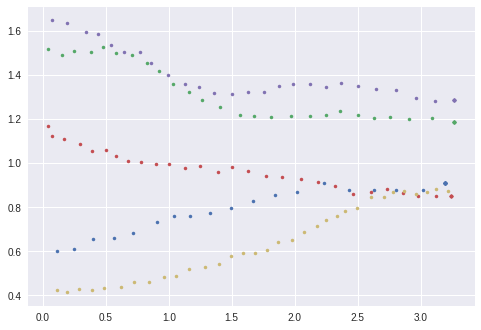

In [ ]:
# Visualiza the Experiment Data
i_d= 0
X, Y= [[]], [[]]
# for i_d, d in enumerate (data):
for i in range (len(d01)): 
    X[i_d].append (np.array (d01[i].x))
    Y[i_d].append (np.array (d01[i].y))
for i in range (len (data[i_d])):
    plt.plot (X[i_d][i], Y[i_d][i], '.');
plt.show ()

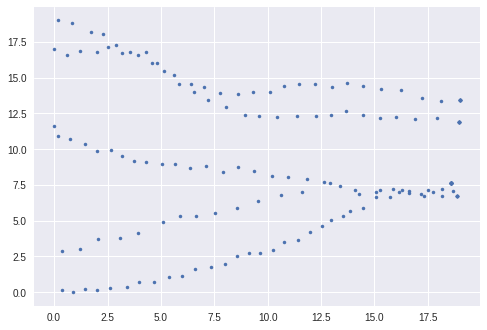

In [ ]:
# Make a single array of the whole data and scale them; Then we feed the array "dataset" to the frame dataset generator.
i_d=0
dataset= np.zeros([1,4])
for i, d in enumerate (d01):
    dataset= np.append (dataset, d.values, axis= 0)
dataset= np.delete (dataset, 0, axis= 0)       
maxscl= 20
# Scale features to range (0,1)
scaler = MinMaxScaler((0,maxscl-1))
dataset[:, [2,3]]= scaler.fit_transform(dataset[:, [2,3]])

plt.plot (dataset[:,2], dataset[:,3], '.')

We will widen the rout lines to better guid the players. 

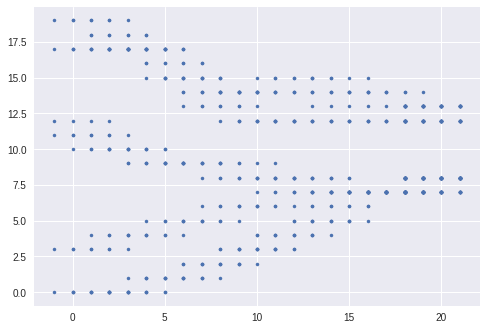

In [ ]:
rts= np.array ([dataset[:,2], dataset[:,3]], dtype= np.float32)
rts= np.uint16(np.rint (rts))

rts_dense= []
for i in range (len(rts[1])):
    for x_ in range (-1, 3):
        # for y_ in range (-1, 2):
            rts_dense.append([rts[0,i] + x_, rts[1,i] + 0])
rts_dense= np.array (rts_dense)
plt.plot (rts_dense[:,0], rts_dense[:,1], '.')

In [ ]:
num_peds= len (np.unique(dataset[:, 1])) 

# Get the frames in dataset, We will train the machine frame by frame, in each frame may be 1-maxNumPed persons in room. 
num_frames = np.unique(dataset[:, 0])

# Initialize the array of frames for the current dataset
frames_dataset = []
for f in num_frames:
    # Get the pedestrians
    frame = dataset[dataset[:, 0] == f, :]
    frames_dataset.append(frame)

frames_dataset= np.array (frames_dataset)

In [ ]:
def make_frame (inp):
    nav= np.zeros ([maxscl*c+1, maxscl*c+1])
    x_inp= np.uint8 (inp[:, -2])
    y_inp= np.uint8 (inp[:, -1])
    nav[x_inp, y_inp] = 1
    return nav
# [np.sum(make_frame (frames_dataset[i])) for i in range (max_len) ]

## RL

In [ ]:
%tensorflow_version 1.x
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import tensorflow as tf
from collections import deque
import time
import random
from tqdm import tqdm

import os
from PIL import Image
import cv2


TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
SIZE= maxscl
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50_000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MODEL_NAME = f'ex{ex}'

MEMORY_FRACTION = 0.20

#  Stats settings
AGGREGATE_STATS_EVERY = 100  # episodes
SHOW_PREVIEW = True

### Own Tensorboard class

In [ ]:
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.FileWriter(self.log_dir)

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)

### Blob

The aim of defining a Blob class is to have pedestrians and their movements. <br>
The coordinates can be initialized from the dataset, or randomly

In [ ]:
class Blob:
    def __init__(self, x_inp= None, y_inp= None):
        if x_inp is None:
            self.x = np.random.randint(0, SIZE)
            self.y = np.random.randint(0, SIZE)
        else:
            self.x = x_inp
            self.y = y_inp

    def action (self, choice):
        '''
        Gives us 6 total movement options. (0,1,2,3,4,5), we encode each posibility of going through doors.
        '''
        if self.x >= SIZE-1 and self.y in door_y: 
            choice= 0
        else: 
            if choice == 0:
                self.move(x=0, y=0)               
            elif choice == 1:
                self.move(x=1, y=1)
            elif choice == 2:
                self.move(x=1, y=-1)
            elif choice == 3:
                self.move(x=1, y=0)
            elif choice == 4:
                self.move(x=0, y=1)
            elif choice == 5:
                self.move(x=0, y=-1)

    def move(self, x=False, y=False):
        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(0, 2)
        else:
            self.x += x
        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y
        # If we have reached door, fix!
        if self.x == SIZE-1 and self.y in door_y:
            self.x = SIZE-1
            # self.y = 
        # If we are out of bounds, fix!
        elif self.x > SIZE-2 and self.y not in door_y:
            self.x = SIZE-2
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1

class Navigation:
    def __init__(self, coo_inp= None):
        if coo_inp is None:
            self.coo= np.random.randint(0, SIZE, size= (num_peds, 2))
        else:
            self.coo= coo_inp


# Put a door in the room
door_y= np.arange(np.floor(min(frames_dataset[-1, :, -1])), np.ceil(max(frames_dataset[-1, :, -1]) ))
door_x= (SIZE-1) * np.ones (len(door_y))
door_coo= np.array(list(zip (door_x, door_y)))
door= Navigation (door_coo)

rts_dense= np.append (rts_dense, door_coo, axis= 0)

In [ ]:
def get_coo (peds):
    X= [peds[i].x for i in range(len(peds))]
    Y= [peds[i].y for i in range(len(peds))]
    return X, Y


### Env

This is where we introduce the rules to players. <br>
If they colide, they loose. <br>
If they hesitate they give penalty <br>
Remaining in denoted lines is appreciated <br>
The ultimate goal is that everyone would be out from doors. 

In [ ]:
class BlobEnv:
    SIZE = maxscl
    RETURN_IMAGES = True

    MOVE_PENALTY = 5
    ENEMY_PENALTY = MOVE_PENALTY + 2
    FOOD_REWARD = 3
    
    OBSERVATION_SPACE_VALUES = (SIZE+1, SIZE, 3)  # 4
    ACTION_SPACE_SIZE = 6
    PLAYER_N = 1  # player key in dict
    FOOD_N = 2  # food key in dict
    ENEMY_N = 3  # enemy key in dict
    d = {1: [(255, i, 0) for i in np.linspace (10, 255, num_peds, dtype= 'int')],
         2: (0, 255, 0),
         3: (0, 0, 255)}

    def reset(self):
        peds= []
        for i in range (num_peds):
            peds.append (Blob (np.rint(frames_dataset[0, i, 2]), np.rint(frames_dataset[0, i, 3])))
        self.player = peds
        self.food = door
        self.episode_step = 0
        observation = np.array(self.get_image())
        return observation

    def step(self, action):
        self.episode_step += 1
        for i in range (num_peds):
            self.player[i].action(action[i])

        new_observation = np.array(self.get_image())

        indir_rew= np.array ([int([self.player[i].x, self.player[i].y] in rts_dense.tolist()) for i in range (num_peds)]) ### check if moved in Directions
        outdir_penalty= np.array ([int([self.player[i].x, self.player[i].y] not in rts_dense.tolist()) for i in range (num_peds)])
        arrival_rew= np.array ([int(self.player[i].x >= SIZE-1 and min(door_y) <= self.player[i].y <= max(door_y)) for i in range (num_peds)])

        collision= np.zeros (num_peds, dtype= 'bool')
        for i in range (0,num_peds-1):
            if self.player[i].x < self.SIZE-1 :
                j= i+1
                coll = False
                while not coll and j<num_peds:
                    coll= [self.player[i].x, self.player[i].y] in np.array(get_coo (self.player)).T.tolist()[j:]
                    collision[[i,j]]+= coll
                    j+= 1

        all_arrived = sum(arrival_rew) == num_peds
        COLL= sum(collision) != 0
        if all_arrived:
            reward = self.FOOD_REWARD*arrival_rew + indir_rew
        else:
            reward = self.FOOD_REWARD*arrival_rew + indir_rew - self.MOVE_PENALTY*outdir_penalty -self.ENEMY_PENALTY * collision
        done = False

        if all_arrived or COLL or self.episode_step >= max_len*1.3:
            done = True

        return new_observation, reward, done

    def render(self, env_rn, plyr):
        env_rn [np.uint8(get_coo(plyr)[0]), np.uint8(get_coo(plyr)[1])]= self.d[self.PLAYER_N]
        return env_rn 

    # FOR CNN #
    def get_image(self):
        env = np.zeros((self.SIZE+1, self.SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
        env [np.uint16(self.food.coo.T)[0], np.uint16(self.food.coo.T)[1]]= self.d[self.FOOD_N]  # sets the food location tile to green color
        env [np.uint16(get_coo(self.player)[0]), np.uint16(get_coo(self.player)[1])]= self.d[self.PLAYER_N]  # sets the player tile to blue
        img = Image.fromarray(env, 'RGB')  
        return img
    def get_env(self):
        env = np.zeros((self.SIZE+1, self.SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
        env [np.uint16(self.food.coo.T)[0], np.uint16(self.food.coo.T)[1]]= self.d[self.FOOD_N]  # sets the food location tile to green color
        return env

env = BlobEnv()

In [ ]:
# env.reset()
# env.step (np.random.randint (0,6,size= 21))
# plt.imshow(env.get_image())
# env.render()

# env.player [2].y

In [ ]:
# i= 3
# j= 4

# env.player[j].x= SIZE-2
# env.player[i].x, env.player[i].y= [env.player[j].x, env.player[j].y]
# np.array(get_coo (env.player)).T.tolist()

# collision= np.zeros (num_peds, dtype = 'bool')
# for i in range (0,num_peds-1):
#     if env.player[i].x < env.SIZE-1 :
#         j= i+1
#         coll = False
#         while not coll and j<num_peds:
#             coll= [env.player[i].x, env.player[i].y] in np.array(get_coo (env.player)).T.tolist()[j:]
#             collision[[i,j]]+= coll 
#             j+= 1
#             print (collision)


In [ ]:
# env.reset()

# for i in range (300):
#     a= env.step(np.random.randint(0,6, size= num_peds))
#     if a[-1] :
#         break
# plt.imshow(env.get_image())

### Agent Class

In [ ]:
# Agent class
class DQNAgent:
    def __init__(self):

        # Main model
        self.model = self.create_model()

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Custom tensorboard object
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()

        model.add(Conv2D(256, (3, 3), input_shape= env.OBSERVATION_SPACE_VALUES))  # OBSERVATION_SPACE_VALUES = (10, 10, 3) a 10x10 RGB image.
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
        model.add(Dense(256))

        model.add(Dense(env.ACTION_SPACE_SIZE * num_peds, activation='linear'))  # ACTION_SPACE_SIZE = how many choices (6)
        model.add(Reshape ([num_peds, env.ACTION_SPACE_SIZE]))
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index], axis= 1) #
                new_q = reward + DISCOUNT * max_future_q                #
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[np.arange(num_peds), action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X)/255, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False,
                       callbacks=[self.tensorboard] if terminal_state else None)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]


agent = DQNAgent()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
print(agent.create_model().summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 19, 18, 256)       7168      
_________________________________________________________________
activation_5 (Activation)    (None, 19, 18, 256)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 256)         590080    
_________________________________________________________________
activation_6 (Activation)    (None, 7, 7, 256)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 256)        

## Iterate over episodes

In [ ]:
if not os.path.isdir('models'):
    os.makedirs('models')

# Environment settings
EPISODES = 25_000
MIN_REWARD = -2  # For model save
# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99951
MIN_EPSILON = 0.05

  0%|          | 26/25000 [00:00<05:36, 74.18episodes/s]

  0%|          | 67/25000 [00:07<25:31, 16.28episodes/s]

  0%|          | 99/25000 [00:18<3:00:35,  2.30episodes/s]

Done in: 1; [ 1 -5 -5 -5 -5]
Done in: 2; [ 1 -5 -5  1 -5]
Done in: 3; [ -5 -12 -12  -5   1]


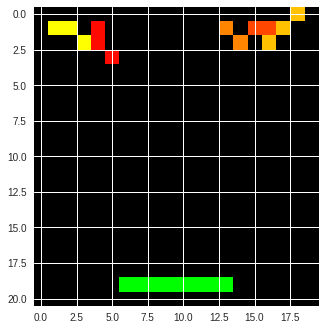

  1%|          | 199/25000 [00:46<1:24:13,  4.91episodes/s]

Done in: 1; [ 1 -5  1  1 -5]
Done in: 2; [ 1 -5  1  1 -5]
Done in: 3; [ 1 -5  1  1 -5]
Done in: 4; [ 1  1  1 -5  1]
Done in: 5; [-5  1  1  1  1]
Done in: 6; [ 1  1  1 -5 -5]
Done in: 7; [-5  1  1 -5 -5]
Done in: 8; [ 1  1  1 -5 -5]
Done in: 9; [-5  1 -5 -5  1]
Done in: 10; [-5 -5  1 -5 -5]
Done in: 11; [-5 -5 -5 -5 -5]
Done in: 12; [ 1 -5 -5 -5  1]
Done in: 13; [ 1 -5 -5 -5 -5]
Done in: 14; [ 1  1  1 -5 -5]
Done in: 15; [ 1 -5 -5 -5 -5]
Done in: 16; [ 1 -5 -5 -5 -5]
Done in: 17; [ 1 -5  1 -5  1]
Done in: 18; [ 1  1  1 -5 -5]
Done in: 19; [ 1  1  1 -5 -5]
Done in: 20; [ 1  1 -5 -5 -5]
Done in: 21; [-5  1 -5 -5 -5]
Done in: 22; [-5 -5 -5 -5 -5]
Done in: 23; [-5  1 -5 -5 -5]
Done in: 24; [ -5   1 -12 -12  -5]


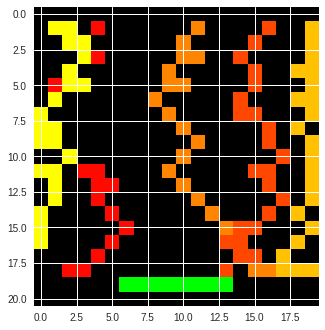

  1%|1         | 299/25000 [01:20<2:19:40,  2.95episodes/s]

Done in: 1; [ 1 -5 -5  1  1]
Done in: 2; [-5 -5  1  1  1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [-5  1  1  1  1]
Done in: 5; [ 1  1  1 -5  1]
Done in: 6; [-5  1 -5  1 -5]
Done in: 7; [ 1  1  1  1 -5]
Done in: 8; [1 1 1 1 1]
Done in: 9; [-5  1 -5 -5  1]
Done in: 10; [-5  1  1 -5  1]
Done in: 11; [-5  1  1 -5  1]
Done in: 12; [-5  1  1 -5  1]
Done in: 13; [-5  1 -5  1 -5]
Done in: 14; [-5  1  1  1  1]
Done in: 15; [-5 -5  1  1  1]
Done in: 16; [-5  1 -5  1 -5]
Done in: 17; [-5 -5  1 -5  1]
Done in: 18; [-5  1 -5  1  1]
Done in: 19; [-5  1 -5  1 -5]
Done in: 20; [-12  -6  -5   1  -5]


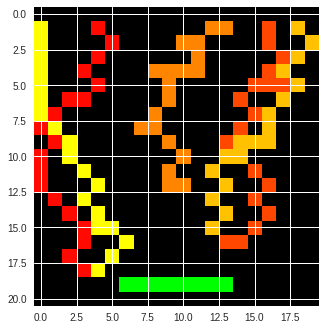

  2%|1         | 399/25000 [02:01<4:07:05,  1.66episodes/s]

Done in: 1; [-5 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [-5  1  1 -5  1]
Done in: 6; [ 1  1  1 -5 -5]
Done in: 7; [ 1  1 -5 -5  1]
Done in: 8; [-5  1  1 -5  1]
Done in: 9; [ 1  1  1 -5  1]
Done in: 10; [-5  1  1 -5 -5]
Done in: 11; [ 1  1  1 -5  1]
Done in: 12; [ 1  1  1 -5  1]
Done in: 13; [ 1 -5 -5 -5  1]
Done in: 14; [-5  1 -5 -5 -5]
Done in: 15; [ 1  1  1 -5  1]
Done in: 16; [ 1  1  1 -5  1]
Done in: 17; [-5  1  1 -5  1]
Done in: 18; [-5 -5  1 -5  1]
Done in: 19; [-5 -5  1 -5  1]
Done in: 20; [ -5 -12  -6  -5   1]


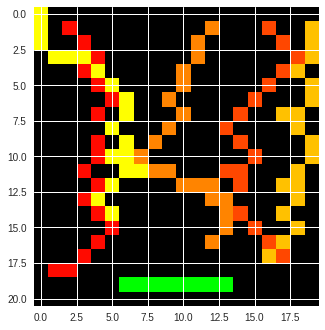

  2%|1         | 497/25000 [02:40<2:05:20,  3.26episodes/s]

Done in: 1; [-5  1 -5  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [ 1  1 -5  1  1]
Done in: 4; [ 1 -5 -5  1  1]
Done in: 5; [ 1 -5  1  1  1]
Done in: 6; [-5 -5 -5  1  1]
Done in: 7; [-5 -5 -5  1  1]
Done in: 8; [ -6 -12  -5  -5   1]


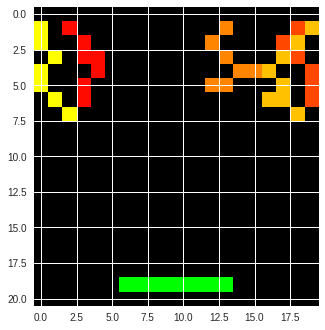

  2%|2         | 599/25000 [03:14<3:02:17,  2.23episodes/s]

Done in: 1; [-5 -5 -5  1 -5]
Done in: 2; [-5 -5 -5  1 -5]
Done in: 3; [ 1 -5 -5  1 -5]
Done in: 4; [ 1 -5  1 -5 -5]
Done in: 5; [ 1 -5 -5 -5 -5]
Done in: 6; [ 1 -5 -5 -5  1]
Done in: 7; [ 1 -6 -6 -5  1]


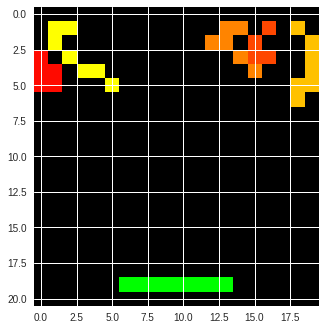

  3%|2         | 698/25000 [03:51<2:42:41,  2.49episodes/s]

Done in: 1; [-5 -5 -5  1  1]
Done in: 2; [-5  1 -5  1 -5]
Done in: 3; [-5 -5 -5  1 -5]
Done in: 4; [ 1  1 -5 -5 -5]
Done in: 5; [ 1  1 -5 -5  1]
Done in: 6; [-6 -6  1 -5  1]


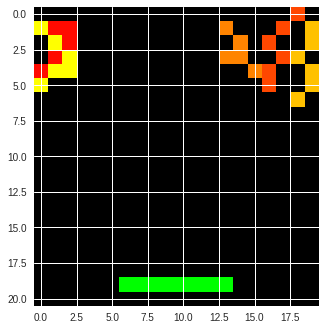

  3%|3         | 799/25000 [04:24<1:53:13,  3.56episodes/s]

Done in: 1; [-5 -5 -5  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [-5  1  1  1  1]
Done in: 4; [-6 -6 -6  1  1]


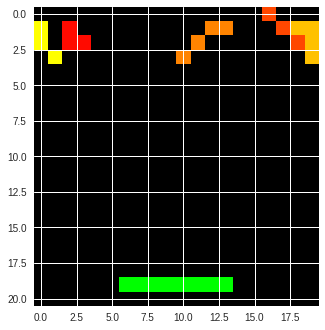

  4%|3         | 898/25000 [05:04<3:51:58,  1.73episodes/s]

Done in: 1; [-5  1 -5  1 -5]
Done in: 2; [ 1  1 -5  1 -5]
Done in: 3; [ -5  -6 -12   1   1]


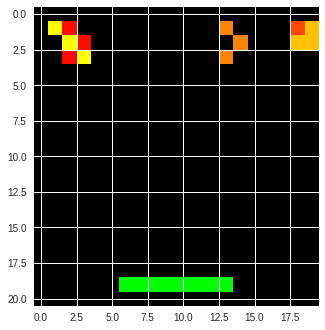

  4%|3         | 998/25000 [05:42<3:13:00,  2.07episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [-5  1  1  1 -5]
Done in: 3; [-5 -6 -6  1  1]


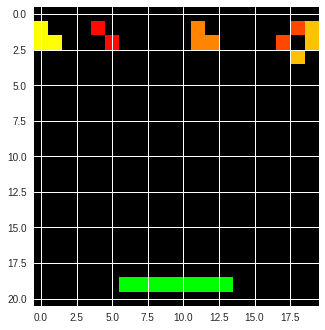

  4%|4         | 1098/25000 [06:19<2:14:45,  2.96episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [-5  1  1  1  1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [ 1  1  1 -5  1]
Done in: 8; [ 1  1 -5  1  1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [ 1 -5 -5  1 -5]
Done in: 12; [-5 -5  1 -5  1]
Done in: 13; [-5 -5  1 -5 -5]
Done in: 14; [ 1 -5  1  1 -5]
Done in: 15; [-5 -5  1  1 -5]
Done in: 16; [  1  -5  -6 -12   1]


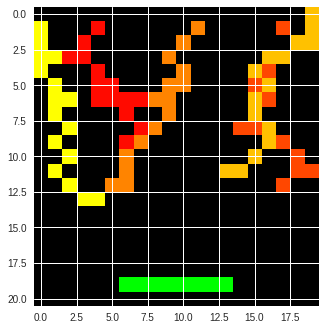

  5%|4         | 1199/25000 [06:59<2:25:43,  2.72episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [ 1 -6 -6  1  1]


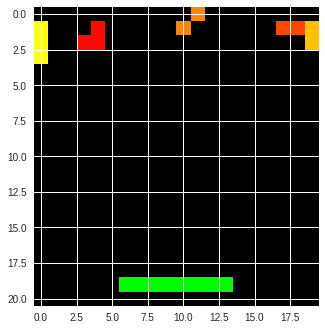

  5%|5         | 1299/25000 [07:37<2:55:04,  2.26episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [-5  1  1  1  1]
Done in: 6; [ 1  1 -5  1  1]
Done in: 7; [-5  1 -5 -5  1]
Done in: 8; [-6 -6 -5 -5  1]


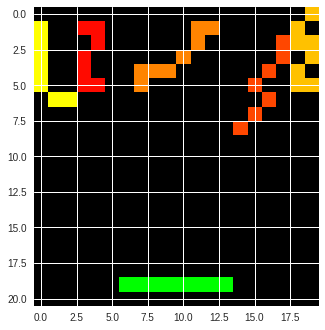

  6%|5         | 1399/25000 [08:20<2:30:52,  2.61episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [  1  -6 -12   1  -5]


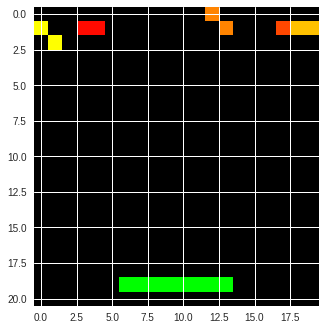

  6%|5         | 1499/25000 [09:07<2:24:26,  2.71episodes/s]

Done in: 1; [ 1  1 -5  1 -5]
Done in: 2; [1 1 1 1 1]
Done in: 3; [-5 -6 -6  1  1]


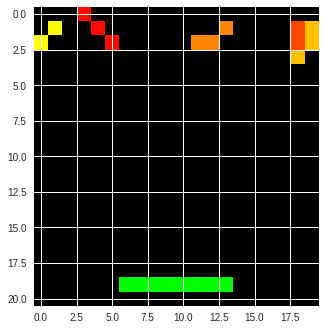

  6%|6         | 1599/25000 [09:51<3:46:09,  1.72episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [-5 -6 -6  1  1]


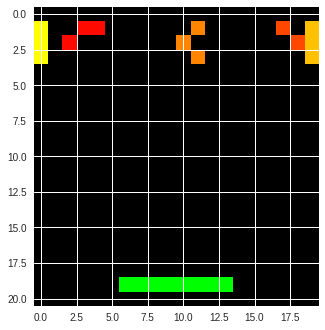

  7%|6         | 1699/25000 [10:34<3:35:40,  1.80episodes/s]

Done in: 1; [-5 -6 -6  1 -5]


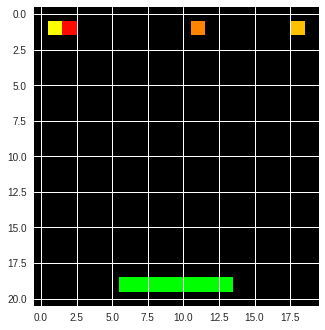

  7%|7         | 1799/25000 [11:23<5:05:38,  1.27episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [-5  1  1  1 -5]
Done in: 3; [ 1  1  1  1 -5]
Done in: 4; [ 1  1 -5  1  1]
Done in: 5; [  1  -6 -12   1  -5]


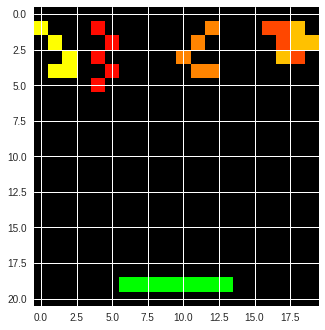

  8%|7         | 1899/25000 [12:12<2:47:36,  2.30episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [ 1  1  1  1 -5]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [-5  1  1  1 -5]
Done in: 10; [ 1  1 -5  1  1]
Done in: 11; [ 1 -5  1  1  1]
Done in: 12; [-5 -5 -5  1  1]
Done in: 13; [ 1 -5  1  1  1]
Done in: 14; [ 1 -5  1  1  1]
Done in: 15; [ 1  1  1 -5  1]
Done in: 16; [ 1 -5  1  1  1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [-5  1  1  1  1]
Done in: 19; [-5  1  1  1  1]
Done in: 20; [-5  1  1  1 -5]
Done in: 21; [-5  1  1  1 -5]
Done in: 22; [-5  1  1  1  4]
Done in: 23; [-6 -6  1  1  4]


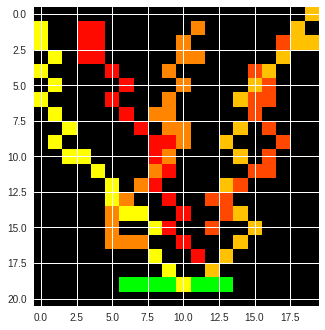

  8%|7         | 1999/25000 [12:57<4:47:04,  1.34episodes/s]

Done in: 1; [-5 -5 -5 -5  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [ 1  1 -5  1  1]
Done in: 5; [ 1  1 -5  1  1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [-5  1 -5 -5  1]
Done in: 8; [ 1  1 -5  1  1]
Done in: 9; [-5  1  1 -5 -5]
Done in: 10; [-5  1  1  1  1]
Done in: 11; [ 1  1  1 -5  1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [ 1  1 -5  1  1]
Done in: 16; [ 1 -5 -5  1  1]
Done in: 17; [-5  1 -5  1 -5]
Done in: 18; [ 1  1 -5  1  1]
Done in: 19; [-5 -5  1  1  1]
Done in: 20; [-5 -5  1  1  1]
Done in: 21; [1 1 4 1 1]
Done in: 22; [-5  1  4  1  1]
Done in: 23; [ 1 -5  4  1 -5]
Done in: 24; [4 1 4 1 1]
Done in: 25; [4 4 4 1 4]
Done in: 26; [4 4 4 1 4]
Done in: 27; [ 4  4  4 -5  4]
Done in: 28; [4 4 4 1 4]
Done in: 29; [4 4 4 1 4]
Done in: 30; [4 4 4 1 4]
Done in: 31; [4 4 4 4 4]


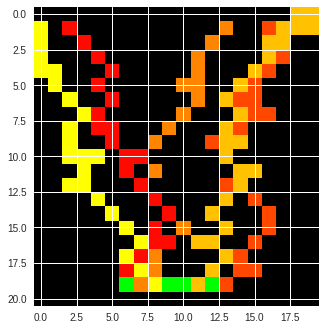

  8%|8         | 2099/25000 [13:46<2:43:50,  2.33episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [ 1 -5  1  1  1]
Done in: 4; [-5  1 -5  1  1]
Done in: 5; [-5 -5  1 -5 -5]
Done in: 6; [ 1  1  1 -5  1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [-5  1  1 -5  1]
Done in: 9; [ 1  1  1 -5  1]
Done in: 10; [ 1  1  1 -5  1]
Done in: 11; [-5  1  1 -5  1]
Done in: 12; [-6 -6  1  1  1]


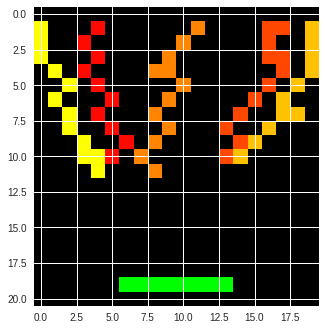

  9%|8         | 2198/25000 [14:34<4:07:53,  1.53episodes/s]

Done in: 1; [ 1 -5 -5  1  1]
Done in: 2; [ 1  1 -5  1  1]
Done in: 3; [ 1  1 -5  1  1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [-5  1  1 -5  1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [-5  1 -5  1  1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [ 1  1 -5  1  1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [ 1 -5  1  1  1]
Done in: 15; [ 1 -5  1  1  1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [ 1 -5  1  1 -5]
Done in: 18; [-5 -5  1 -5 -5]
Done in: 19; [-5 -5  1  1 -5]
Done in: 20; [-5 -5  1  1 -5]
Done in: 21; [-5 -5  1  1 -5]
Done in: 22; [-5 -5  1  1 -5]
Done in: 23; [-5 -5  1  1 -5]
Done in: 24; [-5  1 -5 -5 -5]
Done in: 25; [-12  -3  -5   1  -5]


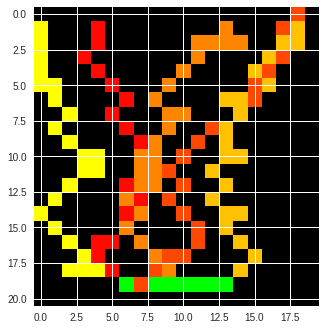

  9%|9         | 2299/25000 [15:22<3:02:46,  2.07episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [ 1  1  1  1 -5]
Done in: 7; [1 1 1 1 1]
Done in: 8; [ 1  1  1  1 -5]
Done in: 9; [ 1  1  1  1 -5]
Done in: 10; [ 1  1  1  1 -5]
Done in: 11; [1 1 1 1 1]
Done in: 12; [ 1  1  1 -5  1]
Done in: 13; [ 1 -5  1  1  1]
Done in: 14; [ 1  1 -5  1  1]
Done in: 15; [ 1  1 -5  1  1]
Done in: 16; [ 1  1 -5  1  1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [ 1  1 -5  1  1]
Done in: 19; [-5  1  1  1  1]
Done in: 20; [-5  1 -5  1  1]
Done in: 21; [ 4  1  1  1 -5]
Done in: 22; [ 4  1 -5 -5  1]
Done in: 23; [ 4 -5 -5  1 -5]
Done in: 24; [ 4 -5  1  1 -5]
Done in: 25; [ 4 -5  1  4 -5]
Done in: 26; [ 4 -5  4  4  4]
Done in: 27; [4 1 4 4 4]
Done in: 28; [4 1 4 4 4]
Done in: 29; [4 1 4 4 4]
Done in: 30; [ 4 -5  4  4  4]
Done in: 31; [4 4 4 4 4]


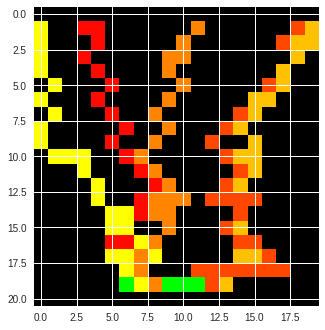

 10%|9         | 2399/25000 [16:11<3:41:40,  1.70episodes/s]

Done in: 1; [ 1 -5  1  1 -5]
Done in: 2; [1 1 1 1 1]
Done in: 3; [ 1 -5  1  1  1]
Done in: 4; [ 1 -5  1  1  1]
Done in: 5; [ 1 -5  1  1  1]
Done in: 6; [ 1  1  1 -5  1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [ 1  1  1 -5  1]
Done in: 9; [ 1 -5  1  1  1]
Done in: 10; [-5 -5  1  1 -5]
Done in: 11; [-5 -5  1  1  1]
Done in: 12; [ 1 -5  1  1  1]
Done in: 13; [ 1 -5  1  1  1]
Done in: 14; [ 1 -5  1 -5  1]
Done in: 15; [-5 -5  1 -5 -5]
Done in: 16; [-5 -5  1 -5  1]
Done in: 17; [-5 -5  1  1  1]
Done in: 18; [1 1 1 1 1]
Done in: 19; [-5  1  1  1  1]
Done in: 20; [-5  1 -5  1  1]
Done in: 21; [ 4  1 -5  1  1]
Done in: 22; [ 4 -5 -5  1  1]
Done in: 23; [ 4  4 -5  4  1]
Done in: 24; [ 4  4 -5  4  1]
Done in: 25; [ 4  4 -5  4  1]
Done in: 26; [ 4  4 -5  4  1]
Done in: 27; [ 4  4 -5  4  4]
Done in: 28; [ 4  4 -5  4  4]
Done in: 29; [ 4  4 -5  4  4]
Done in: 30; [ 4  4 -5  4  4]
Done in: 31; [ 4  4 -5  4  4]
Done in: 32; [ 4  4 -5  4  4]
Done in: 33; [ 4  4 -5  4  4]
Done in: 34; [ 4  4 -5  4  4]
Done

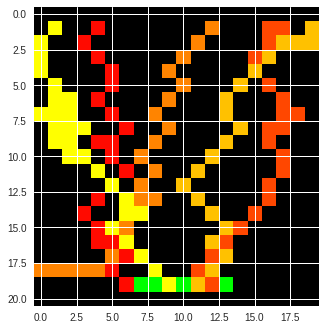

 10%|9         | 2499/25000 [17:01<4:40:29,  1.34episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [-5  1  1 -5  1]
Done in: 5; [ 1 -5  1 -5 -5]
Done in: 6; [ 1 -5  1 -5  1]
Done in: 7; [ 1  1  1 -5  1]
Done in: 8; [ 1  1  1 -5  1]
Done in: 9; [ 1  1  1 -5  1]
Done in: 10; [ 1  1  1 -5  1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [ 1  1  1  1 -5]
Done in: 17; [1 1 1 1 1]
Done in: 18; [ 1  1  1  1 -5]
Done in: 19; [ 1  1 -5  1  1]
Done in: 20; [ 1  1 -5 -5  1]
Done in: 21; [ 1  1  1 -5 -5]
Done in: 22; [-6 -6  1  4  4]


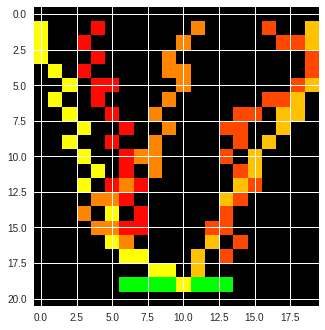

 10%|#         | 2599/25000 [17:54<3:54:04,  1.59episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [ 1 -5  1  1  1]
Done in: 6; [ 1 -5  1 -5  1]
Done in: 7; [-5 -5 -5  1  1]
Done in: 8; [ 1 -5 -5 -5  1]
Done in: 9; [ 1 -5  1  1  1]
Done in: 10; [ 1 -5  1 -5  1]
Done in: 11; [ 1  1 -5 -5  1]
Done in: 12; [ 1  1  1 -5  1]
Done in: 13; [ 1  1 -5 -5  1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [ 1  1  1  1 -5]
Done in: 17; [ 1  1  1 -5  1]
Done in: 18; [1 1 1 1 1]
Done in: 19; [1 1 1 1 1]
Done in: 20; [ 1  1 -5  1  1]
Done in: 21; [4 1 4 1 1]
Done in: 22; [4 1 4 1 1]
Done in: 23; [4 1 4 1 1]
Done in: 24; [4 1 4 1 1]
Done in: 25; [ 4  1  4 -5  1]
Done in: 26; [ 4 -5  4  4  1]
Done in: 27; [4 1 4 4 1]
Done in: 28; [4 1 4 4 4]
Done in: 29; [4 4 4 4 4]


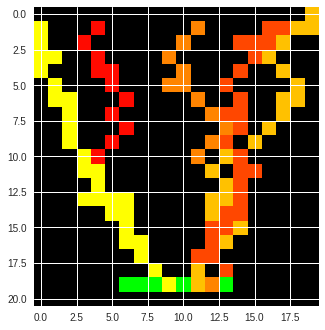

 11%|#         | 2699/25000 [18:49<3:25:40,  1.81episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [-5  1 -5  1 -5]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [ 1 -5  1  1 -5]
Done in: 15; [1 1 1 1 1]
Done in: 16; [ 1  1  1 -5 -5]
Done in: 17; [ 1  1 -5  1  1]
Done in: 18; [ 1  1 -5  1 -5]
Done in: 19; [ 1  1 -5  1  1]
Done in: 20; [ 1  1 -5  1  4]
Done in: 21; [1 1 4 1 4]
Done in: 22; [ 1 -5  4  1  4]
Done in: 23; [ 1 -5  4 -5  4]
Done in: 24; [-5 -5  4  4  4]
Done in: 25; [ 1 -5  4  4  4]
Done in: 26; [4 1 4 4 4]
Done in: 27; [4 4 4 4 4]


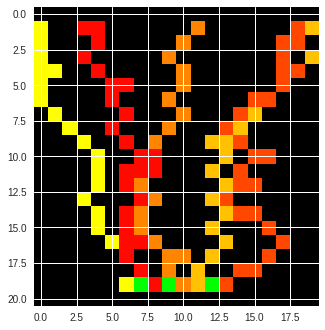

 11%|#1        | 2799/25000 [19:46<4:04:26,  1.51episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [ 1 -5  1  1  1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [ 1  1  1 -5  1]
Done in: 10; [ 1  1  1 -5 -5]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [ 1  1  1  1 -5]
Done in: 14; [ -6 -12   1   1   1]


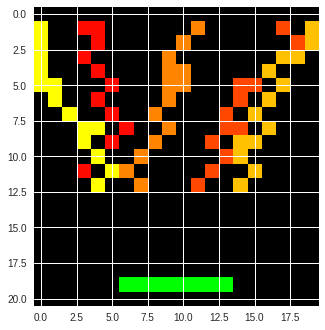

 12%|#1        | 2899/25000 [20:43<3:42:00,  1.66episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [ 1  1 -5  1  1]
Done in: 5; [ 1  1  1  1 -5]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [ 1 -5  1  1  1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [ 1 -5  1  1  1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [ 1  1  1 -5  1]
Done in: 18; [ 1  1 -5  1  1]
Done in: 19; [ 1  1 -5  1  1]
Done in: 20; [ 1  1 -5  1  1]
Done in: 21; [-5 -5 -5  1  1]
Done in: 22; [ 4  1 -5  1  1]
Done in: 23; [ 4  4 -5  1 -5]
Done in: 24; [ 4  4 -5 -5 -5]
Done in: 25; [ 4  4 -5  1 -5]
Done in: 26; [ 4  4 -5  1 -5]
Done in: 27; [ 4  4 -5  1  1]
Done in: 28; [ 4  4 -5  1  4]
Done in: 29; [ 4  4 -5  1  4]
Done in: 30; [4 4 4 1 4]
Done in: 31; [4 4 4 1 4]
Done in: 32; [4 4 4 4 4]


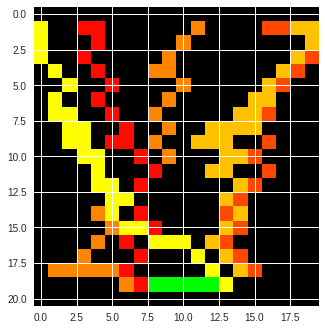

 12%|#1        | 2999/25000 [21:38<4:01:19,  1.52episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [ 1  1 -5  1  1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [-5  1  1  1 -5]
Done in: 13; [1 1 1 1 1]
Done in: 14; [ 1  1 -5  1 -5]
Done in: 15; [ 1  1 -5  1 -5]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [ 1 -5  1  1 -5]
Done in: 19; [ 1  1  1  1 -5]
Done in: 20; [-5  1 -5  1 -5]
Done in: 21; [  1   1 -12  -6  -5]


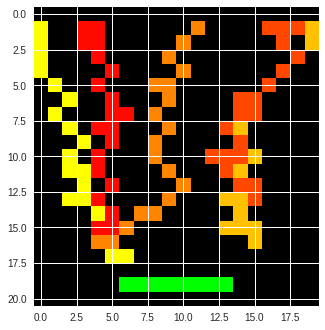

 12%|#2        | 3099/25000 [22:33<3:17:56,  1.84episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [-5 -5 -5  1  1]
Done in: 5; [ 1 -5  1  1  1]
Done in: 6; [ 1  1 -5  1 -5]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [-5  1 -5 -5  1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [-5  1  1  1  1]
Done in: 18; [ 1  1 -5  1  1]
Done in: 19; [ 1  1 -5  1  1]
Done in: 20; [ 1  1 -5 -5 -5]
Done in: 21; [ 1  1  4  1 -5]
Done in: 22; [-5  4  4  1  4]
Done in: 23; [1 4 4 1 4]
Done in: 24; [-5  4  4  1  4]
Done in: 25; [-5  4  4  1  4]
Done in: 26; [4 4 4 1 4]
Done in: 27; [4 4 4 1 4]
Done in: 28; [4 4 4 1 4]
Done in: 29; [4 4 4 4 4]


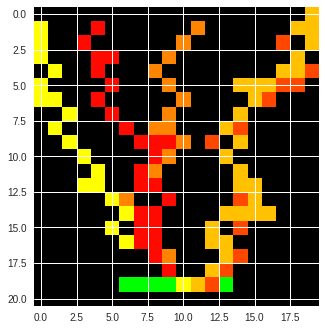

 13%|#2        | 3198/25000 [23:35<3:09:44,  1.91episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [-5  1 -5  1  1]
Done in: 4; [-5  1 -5  1 -5]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [ 1  1  1 -5 -5]
Done in: 8; [ 1  1  1 -5  1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [ 1 -5  1  1  1]
Done in: 12; [ 1 -5 -5  1  1]
Done in: 13; [ 1 -5 -5  1 -5]
Done in: 14; [ 1  1  1  1 -5]
Done in: 15; [ 1  1 -5 -5 -5]
Done in: 16; [1 1 1 1 1]
Done in: 17; [ 1  1 -5  1  1]
Done in: 18; [1 1 1 1 1]
Done in: 19; [-5  1  1  1  1]
Done in: 20; [1 4 1 1 1]
Done in: 21; [ 4  4  4 -5  1]
Done in: 22; [4 4 4 1 1]
Done in: 23; [4 4 4 1 1]
Done in: 24; [4 4 4 1 1]
Done in: 25; [4 4 4 1 1]
Done in: 26; [ 4  4  4  1 -5]
Done in: 27; [4 4 4 1 1]
Done in: 28; [ 4  4  4  4 -5]
Done in: 29; [ 4  4  4  4 -5]
Done in: 30; [ 4  4  4  4 -5]
Done in: 31; [ 4  4  4  4 -5]
Done in: 32; [ 4  4  4  4 -5]
Done in: 33; [ 4  4  4  4 -5]
Done in: 34; [ 4  4  4  4 -5]
Done in: 35; [ 4  4  4  4 -5]
Done in: 36; [ 4  4  4  4 -5]

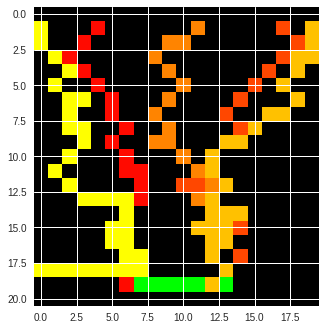

 13%|#3        | 3299/25000 [24:33<4:29:50,  1.34episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [ 1  1 -5  1  1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [ 1  1 -5  1  1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [-5  1  1  1  1]
Done in: 9; [-5 -5  1  1  1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [ 1 -5  1  1  1]
Done in: 13; [ 1  1  1  1 -5]
Done in: 14; [ 1  1  1  1 -5]
Done in: 15; [-5  1  1  1  1]
Done in: 16; [-5 -5  1  1 -5]
Done in: 17; [-5 -5  1  1  1]
Done in: 18; [-5 -5  1  1  1]
Done in: 19; [-5  4  1  1  1]
Done in: 20; [-5  4 -5  1  1]
Done in: 21; [-5  4  1  1  1]
Done in: 22; [-5  4  4  1  1]
Done in: 23; [-5  4  4  1  1]
Done in: 24; [-5  4  4  1  1]
Done in: 25; [ 4  4  4  1 -5]
Done in: 26; [4 4 4 1 1]
Done in: 27; [4 4 4 1 4]
Done in: 28; [4 4 4 1 4]
Done in: 29; [4 4 4 1 4]
Done in: 30; [4 4 4 4 4]


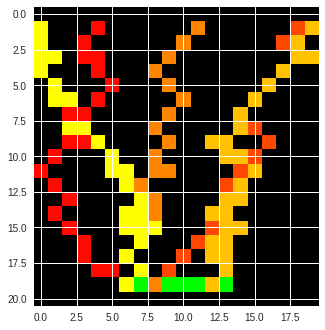

 14%|#3        | 3399/25000 [25:32<3:58:30,  1.51episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [-5  1  1  1  1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [ 1 -5  1  1  1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [ 1 -5  1  1 -5]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [-5  1  1  1 -5]
Done in: 12; [-5  1  1  1  1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [ 1 -5  1  1  1]
Done in: 15; [ 1 -5  1 -5 -5]
Done in: 16; [ -6 -12   1   1   1]


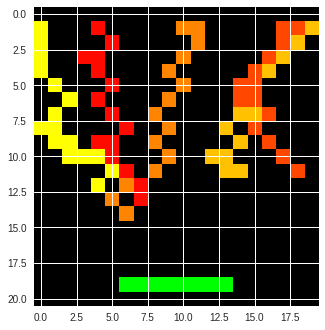

 14%|#3        | 3499/25000 [26:38<3:21:04,  1.78episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [ 1  1 -5  1 -5]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [-5  1 -5  1  1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [-5  1  1  1  1]
Done in: 14; [ 1  1  1 -5 -5]
Done in: 15; [ 1  1  1  1 -5]
Done in: 16; [ 1  1  1 -5 -5]
Done in: 17; [ 1  1  1  1 -5]
Done in: 18; [ 1  1  1  1 -5]
Done in: 19; [ 1  1  1  1 -5]
Done in: 20; [-5  1  1  1 -5]
Done in: 21; [-5  1  1  1 -5]
Done in: 22; [ 4  4  1  1 -5]
Done in: 23; [ 4  4  1  1 -5]
Done in: 24; [4 4 1 4 4]
Done in: 25; [4 4 4 4 4]


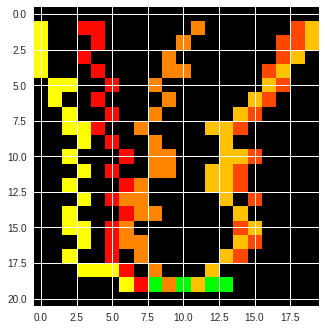

 14%|#4        | 3599/25000 [27:53<4:40:14,  1.27episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [ 1  1  1 -5  1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [-5  1  1  1  1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [-5  1  1 -5  1]
Done in: 19; [-5  1 -5  1  1]
Done in: 20; [ 4  1 -5  1  1]
Done in: 21; [ 4  1 -5  1  1]
Done in: 22; [ 4  4 -5  1  1]
Done in: 23; [ 4  4 -5  1  4]
Done in: 24; [ 4  4 -5  1  4]
Done in: 25; [ 4  4 -5  1  4]
Done in: 26; [4 4 4 4 4]


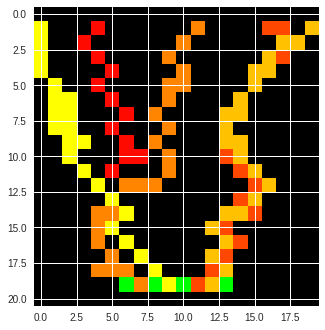

 15%|#4        | 3699/25000 [29:07<4:28:43,  1.32episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [-5  1  1  1  1]
Done in: 4; [ 1 -5  1  1  1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [ 1  1 -5  1  1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [ 1  1  1  1 -5]
Done in: 10; [-5  1 -5  1  1]
Done in: 11; [-5  1 -5  1  1]
Done in: 12; [ 1  1  1 -5  1]
Done in: 13; [ 1 -5 -5  1  1]
Done in: 14; [-5 -5 -5 -5  1]
Done in: 15; [-5  1 -5  1  1]
Done in: 16; [ 1  1 -5 -5  1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [ 1  1 -5  1  1]
Done in: 19; [ 1  1 -5  1  1]
Done in: 20; [ 1  1 -5  1  1]
Done in: 21; [ 1  4  1  1 -5]
Done in: 22; [ 1  4  4  1 -5]
Done in: 23; [-5  4  4  1 -5]
Done in: 24; [1 4 4 1 4]
Done in: 25; [1 4 4 1 4]
Done in: 26; [1 4 4 1 4]
Done in: 27; [-5  4  4  4  4]
Done in: 28; [1 4 4 4 4]
Done in: 29; [-5  4  4  4  4]
Done in: 30; [1 4 4 4 4]
Done in: 31; [1 4 4 4 4]
Done in: 32; [1 4 4 4 4]
Done in: 33; [4 4 4 4 4]


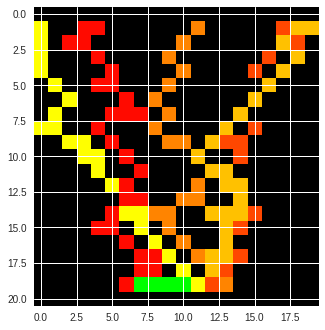

 15%|#5        | 3799/25000 [30:19<4:38:17,  1.27episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [ 1 -5 -5  1  1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [ 1  1 -5  1  1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [ 1  1  1  1 -5]
Done in: 11; [ 1  1  1  1 -5]
Done in: 12; [ 1  1  1  1 -5]
Done in: 13; [ 1  1  1  1 -5]
Done in: 14; [ 1  1  1  1 -5]
Done in: 15; [ 1 -5  1  1  1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [1 1 1 1 1]
Done in: 19; [-5  1  1  1  1]
Done in: 20; [-5  4  1  1  4]
Done in: 21; [4 4 1 1 4]
Done in: 22; [ 4  4 -5  1  4]
Done in: 23; [ 4  4 -5  1  4]
Done in: 24; [4 4 4 1 4]
Done in: 25; [4 4 4 1 4]
Done in: 26; [4 4 4 1 4]
Done in: 27; [4 4 4 1 4]
Done in: 28; [4 4 4 1 4]
Done in: 29; [4 4 4 1 4]
Done in: 30; [ 4  4  4 -5  4]
Done in: 31; [ 4  4  4 -5  4]
Done in: 32; [ 4  4  4 -5  4]
Done in: 33; [4 4 4 1 4]
Done in: 34; [4 4 4 1 4]
Done in: 35; [4 4 4 1 4]
Done in: 36; [ 4  4  4 -5  4]
Done in: 37; [4 4 4 4 4]

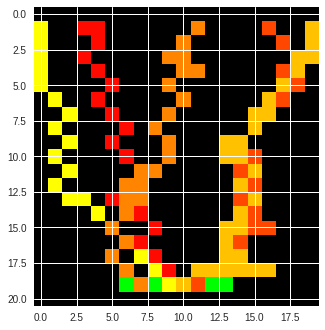

 16%|#5        | 3899/25000 [31:39<3:36:13,  1.63episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [ 1  1 -5  1  1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [ 1  1 -5  1 -5]
Done in: 10; [-5  1  1  1  1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [ 1 -5  1  1  1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [ 1  1 -5 -5  1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [-5  1  1  1  1]
Done in: 19; [-5 -5  1  1 -5]
Done in: 20; [-5  4 -5  1 -5]
Done in: 21; [ 4  4 -5  1  4]
Done in: 22; [ 4  4 -5  1  4]
Done in: 23; [4 4 4 1 4]
Done in: 24; [4 4 4 1 4]
Done in: 25; [4 4 4 1 4]
Done in: 26; [4 4 4 1 4]
Done in: 27; [4 4 4 1 4]
Done in: 28; [4 4 4 4 4]


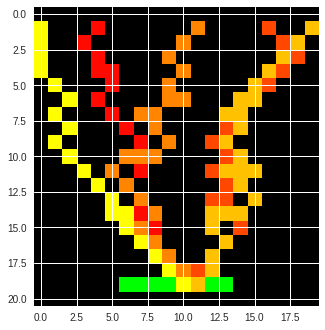

 16%|#5        | 3999/25000 [32:51<4:22:41,  1.33episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [ 1  1 -5  1  1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [ 1 -5  1  1  1]
Done in: 13; [ 1  1  1  1 -5]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [1 1 1 1 1]
Done in: 19; [ 1  1 -5  1  1]
Done in: 20; [ 1  1 -5  1  1]
Done in: 21; [ 1  1 -5  1  1]
Done in: 22; [ 1  1  4 -5  1]
Done in: 23; [-5  4  4  4 -5]
Done in: 24; [1 4 4 4 4]
Done in: 25; [-5  4  4  4  4]
Done in: 26; [4 4 4 4 4]


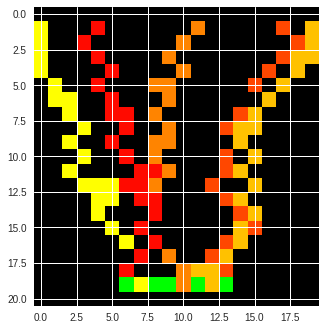

 16%|#6        | 4099/25000 [34:03<4:34:04,  1.27episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [-5  1 -5  1  1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [ 1 -5  1  1  1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [-5  1  1  1  1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [ 1  1 -5  1  1]
Done in: 19; [ 1  1 -5  1  1]
Done in: 20; [ 1 -5 -5  1 -5]
Done in: 21; [ 1 -5 -5  1 -5]
Done in: 22; [-5  4 -5  1  4]
Done in: 23; [ 1  4 -5  1  4]
Done in: 24; [ 4  4 -5 -5  4]
Done in: 25; [ 4  4 -5 -5  4]
Done in: 26; [ 4  4 -5 -5  4]
Done in: 27; [ 4  4 -5 -5  4]
Done in: 28; [ 4  4 -5 -5  4]
Done in: 29; [ 4  4 -5 -5  4]
Done in: 30; [ 4  4 -5 -5  4]
Done in: 31; [ 4  4  4 -5  4]
Done in: 32; [ 4  4  4 -5  4]
Done in: 33; [ 4  4  4 -5  4]
Done in: 34; [4 4 4 1 4]
Done in: 35; [4 4 4 1 4]
Done in: 36; [4 4 4 4 4]


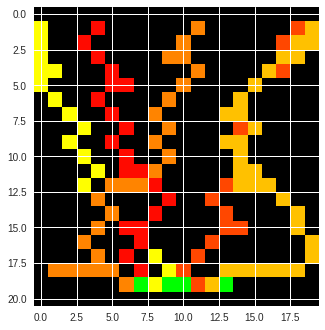

 17%|#6        | 4199/25000 [35:18<3:56:55,  1.46episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [ 1  1  1  1 -5]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [ 1 -6 -6  1  1]


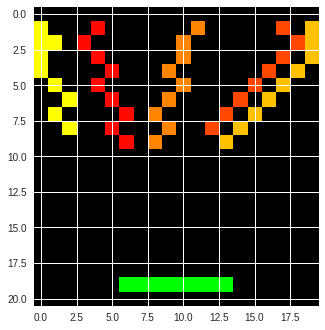

 17%|#7        | 4299/25000 [36:36<3:10:49,  1.81episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [ 1  1 -5  1  1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [-5 -5  1  1  1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [ 1  1  1  1 -5]
Done in: 19; [1 1 1 1 1]
Done in: 20; [ 1 -5  1  1  4]
Done in: 21; [1 4 1 1 4]
Done in: 22; [1 4 1 1 4]
Done in: 23; [-5  4  1  1  4]
Done in: 24; [-5  4  1  1  4]
Done in: 25; [4 4 1 4 4]
Done in: 26; [4 4 1 4 4]
Done in: 27; [4 4 1 4 4]
Done in: 28; [4 4 1 4 4]
Done in: 29; [4 4 1 4 4]
Done in: 30; [4 4 1 4 4]
Done in: 31; [ 4  4 -5  4  4]
Done in: 32; [4 4 4 4 4]


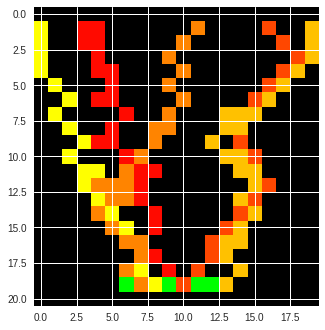

 18%|#7        | 4399/25000 [37:52<3:55:21,  1.46episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [ 1  1 -5  1  1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [ 1  1  1  1 -5]
Done in: 19; [ 1  4  1  1 -5]
Done in: 20; [ 1  4  1  1 -5]
Done in: 21; [-5  4  1  1  4]
Done in: 22; [-5  4 -5  1  4]
Done in: 23; [4 4 1 1 4]
Done in: 24; [4 4 4 1 4]
Done in: 25; [4 4 4 1 4]
Done in: 26; [ 4  4  4 -5  4]
Done in: 27; [4 4 4 4 4]


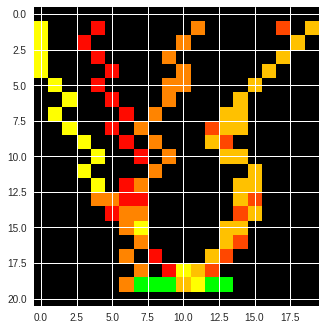

 18%|#7        | 4499/25000 [39:13<4:10:19,  1.36episodes/s]

Done in: 1; [1 1 1 1 1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [-5  1  1  1  1]
Done in: 18; [-5  1  1  1  1]
Done in: 19; [-5 -5  1  1  1]
Done in: 20; [4 4 1 1 1]
Done in: 21; [4 4 1 1 4]
Done in: 22; [ 4  4  1 -5  4]
Done in: 23; [4 4 1 4 4]
Done in: 24; [ 4  4 -5  4  4]
Done in: 25; [4 4 1 4 4]
Done in: 26; [ 4  4 -5  4  4]
Done in: 27; [4 4 1 4 4]
Done in: 28; [4 4 4 4 4]


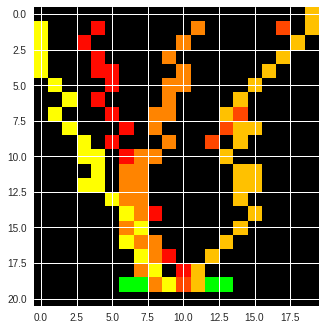

 18%|#8        | 4599/25000 [40:36<4:29:47,  1.26episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [ 1 -5  1  1 -5]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [1 1 1 1 1]
Done in: 19; [ 1  1 -5  1  1]
Done in: 20; [ 1  4 -5  1  1]
Done in: 21; [ 1  4 -5  1  4]
Done in: 22; [ 1  4 -5  1  4]
Done in: 23; [-5  4  4  1  4]
Done in: 24; [1 4 4 1 4]
Done in: 25; [-5  4  4  1  4]
Done in: 26; [1 4 4 1 4]
Done in: 27; [1 4 4 1 4]
Done in: 28; [4 4 4 1 4]
Done in: 29; [4 4 4 1 4]
Done in: 30; [4 4 4 1 4]
Done in: 31; [4 4 4 1 4]
Done in: 32; [4 4 4 4 4]


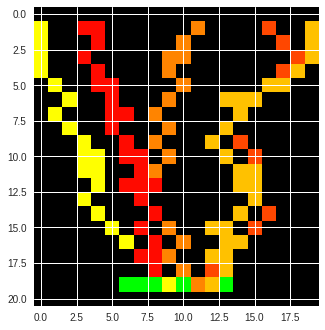

 19%|#8        | 4699/25000 [41:52<4:43:29,  1.19episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [ 1 -5  1  1  1]
Done in: 19; [-5  4  1  1  4]
Done in: 20; [-5  4 -5  1  4]
Done in: 21; [4 4 1 1 4]
Done in: 22; [4 4 4 1 4]
Done in: 23; [4 4 4 1 4]
Done in: 24; [4 4 4 1 4]
Done in: 25; [4 4 4 1 4]
Done in: 26; [4 4 4 1 4]
Done in: 27; [4 4 4 4 4]


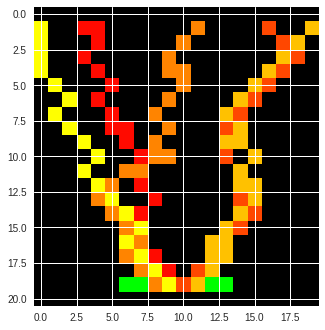

 19%|#9        | 4799/25000 [43:11<4:24:23,  1.27episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [-5  1 -5  1  1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [ 1 -5  1 -5  1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [ 1  1  1 -5  1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [ 1  1  1  1 -5]
Done in: 18; [ 1 -5  1  1  1]
Done in: 19; [-5 -5  1  1  1]
Done in: 20; [ 1 -5  1 -5  1]
Done in: 21; [ 1  1  1 -5  1]
Done in: 22; [4 1 1 4 1]
Done in: 23; [4 1 1 4 1]
Done in: 24; [4 1 1 4 1]
Done in: 25; [4 4 1 4 1]
Done in: 26; [4 4 1 4 1]
Done in: 27; [4 4 1 4 1]
Done in: 28; [4 4 1 4 1]
Done in: 29; [4 4 4 4 1]
Done in: 30; [4 4 4 4 1]
Done in: 31; [ 4  4  4  4 -5]
Done in: 32; [4 4 4 4 1]
Done in: 33; [4 4 4 4 4]


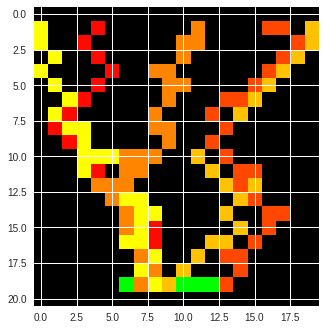

 20%|#9        | 4899/25000 [44:34<3:34:52,  1.56episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [-5  1  1  1 -5]
Done in: 10; [ 1 -5 -5 -5  1]
Done in: 11; [-5  1  1  1  1]
Done in: 12; [-5 -5  1  1  1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [ 1  1  1  1 -5]
Done in: 17; [ 1  1  1  1 -5]
Done in: 18; [ 1  1  1  1 -5]
Done in: 19; [-5  1  1  1  4]
Done in: 20; [-5  1  1  1  4]
Done in: 21; [-5  4  1  1  4]
Done in: 22; [4 4 1 1 4]
Done in: 23; [4 4 1 1 4]
Done in: 24; [4 4 1 1 4]
Done in: 25; [4 4 1 1 4]
Done in: 26; [ 4  4 -5  1  4]
Done in: 27; [ 4  4 -5  4  4]
Done in: 28; [ 4  4 -5  4  4]
Done in: 29; [ 4  4 -5  4  4]
Done in: 30; [ 4  4 -5  4  4]
Done in: 31; [ 4  4 -5  4  4]
Done in: 32; [ 4  4 -5  4  4]
Done in: 33; [ 4  4 -5  4  4]
Done in: 34; [ 4  4 -5  4  4]
Done in: 35; [ 4  4 -5  4  4]
Done in: 36; [ 4  4 -5  4  4]

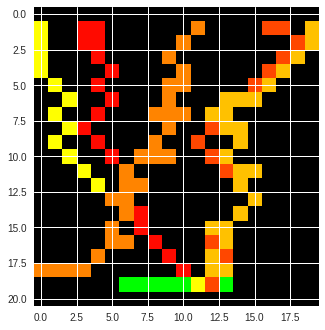

 20%|#9        | 4999/25000 [45:54<5:05:13,  1.09episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [ 1  1 -5  1  1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [1 1 1 1 1]
Done in: 19; [1 1 1 1 4]
Done in: 20; [1 1 1 1 4]
Done in: 21; [1 4 1 1 4]
Done in: 22; [ 1  4 -5  1  4]
Done in: 23; [ 1  4 -5  4  4]
Done in: 24; [1 4 1 4 4]
Done in: 25; [-5  4  4  4  4]
Done in: 26; [1 4 4 4 4]
Done in: 27; [-5  4  4  4  4]
Done in: 28; [4 4 4 4 4]


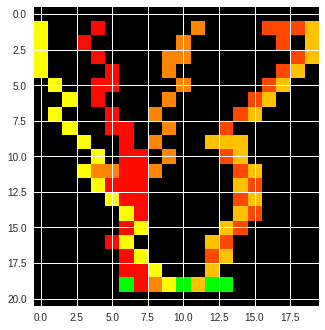

 20%|##        | 5099/25000 [47:20<5:27:26,  1.01episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [ 1 -5  1  1 -5]
Done in: 3; [ 1 -5  1  1  1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [ 1  1  1  1 -5]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [1 1 1 1 1]
Done in: 19; [1 4 1 1 1]
Done in: 20; [ 1  4 -5  1  1]
Done in: 21; [-5  4 -5  1  4]
Done in: 22; [-5  4 -5  1  4]
Done in: 23; [4 4 4 1 4]
Done in: 24; [4 4 4 1 4]
Done in: 25; [4 4 4 1 4]
Done in: 26; [4 4 4 1 4]
Done in: 27; [4 4 4 1 4]
Done in: 28; [4 4 4 1 4]
Done in: 29; [ 4  4  4 -5  4]
Done in: 30; [ 4  4  4 -5  4]
Done in: 31; [ 4  4  4 -5  4]
Done in: 32; [4 4 4 1 4]
Done in: 33; [4 4 4 4 4]


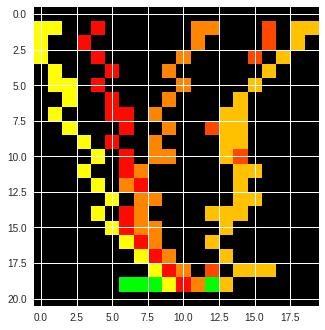

 21%|##        | 5199/25000 [48:46<4:31:15,  1.22episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [-5  1  1  1  1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [ 1 -6 -6  1  1]


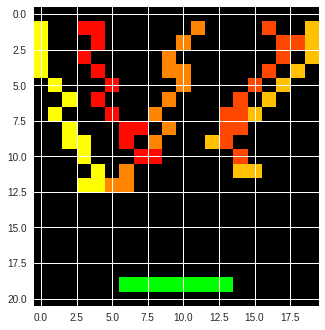

 21%|##1       | 5299/25000 [50:09<5:01:00,  1.09episodes/s]

Done in: 1; [ 1 -5  1  1  1]
Done in: 2; [1 1 1 1 1]
Done in: 3; [ 1  1  1  1 -5]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [1 1 1 1 1]
Done in: 19; [ 1  4 -5  1  1]
Done in: 20; [ 1  4 -5  1  4]
Done in: 21; [ 1  4 -5  1  4]
Done in: 22; [-5  4  4  1  4]
Done in: 23; [-5  4  4  1  4]
Done in: 24; [4 4 4 1 4]
Done in: 25; [4 4 4 1 4]
Done in: 26; [4 4 4 1 4]
Done in: 27; [4 4 4 1 4]
Done in: 28; [4 4 4 1 4]
Done in: 29; [4 4 4 1 4]
Done in: 30; [4 4 4 1 4]
Done in: 31; [4 4 4 1 4]
Done in: 32; [4 4 4 1 4]
Done in: 33; [4 4 4 1 4]
Done in: 34; [4 4 4 1 4]
Done in: 35; [ 4  4  4 -5  4]
Done in: 36; [4 4 4 4 4]


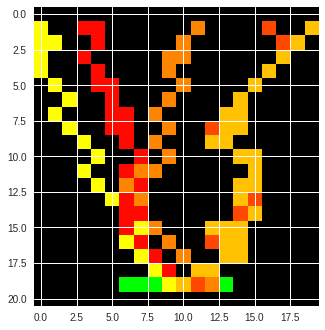

 22%|##1       | 5399/25000 [51:37<5:23:40,  1.01episodes/s]

Done in: 1; [ 1 -5  1  1 -5]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [1 1 1 1 1]
Done in: 8; [1 1 1 1 1]
Done in: 9; [1 1 1 1 1]
Done in: 10; [1 1 1 1 1]
Done in: 11; [1 1 1 1 1]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [ 1 -5  1  1  1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [1 1 1 1 1]
Done in: 19; [-5 -5  1  1 -5]
Done in: 20; [ 1  1  1  1 -5]
Done in: 21; [-5 -5  1  1 -5]
Done in: 22; [-5 -5  1  1 -5]
Done in: 23; [-5  1  1  1 -5]
Done in: 24; [4 1 1 4 4]
Done in: 25; [4 1 1 4 4]
Done in: 26; [4 4 1 4 4]
Done in: 27; [4 4 1 4 4]
Done in: 28; [4 4 1 4 4]
Done in: 29; [4 4 1 4 4]
Done in: 30; [4 4 1 4 4]
Done in: 31; [4 4 1 4 4]
Done in: 32; [ 4  4 -5  4  4]
Done in: 33; [4 4 1 4 4]
Done in: 34; [ 4  4 -5  4  4]
Done in: 35; [4 4 1 4 4]
Done in: 36; [4 4 1 4 4]
Done in: 37; [4 4 4 4 4]


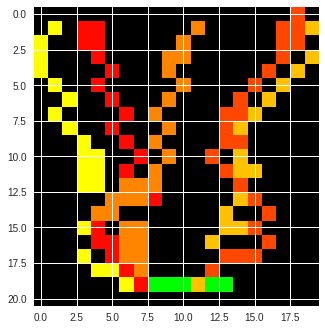

 22%|##1       | 5499/25000 [53:06<5:10:24,  1.05episodes/s]

Done in: 1; [-5 -5  1  1 -5]
Done in: 2; [1 1 1 1 1]
Done in: 3; [1 1 1 1 1]
Done in: 4; [1 1 1 1 1]
Done in: 5; [1 1 1 1 1]
Done in: 6; [1 1 1 1 1]
Done in: 7; [-5  1  1 -5 -5]
Done in: 8; [ 1  1  1 -5 -5]
Done in: 9; [ 1  1  1 -5  1]
Done in: 10; [ 1  1  1  1 -5]
Done in: 11; [ 1  1  1  1 -5]
Done in: 12; [1 1 1 1 1]
Done in: 13; [1 1 1 1 1]
Done in: 14; [1 1 1 1 1]
Done in: 15; [1 1 1 1 1]
Done in: 16; [1 1 1 1 1]
Done in: 17; [1 1 1 1 1]
Done in: 18; [1 1 1 1 1]
Done in: 19; [-5  1  1  1  1]
Done in: 20; [ 4 -5 -5  1  1]
Done in: 21; [ 4  4 -5  1  1]
Done in: 22; [ 4  4 -5  1  1]
Done in: 23; [ 4  4  4  1 -5]
Done in: 24; [4 4 4 1 1]
Done in: 25; [4 4 4 1 1]
Done in: 26; [4 4 4 1 4]
Done in: 27; [4 4 4 1 4]
Done in: 28; [4 4 4 1 4]
Done in: 29; [4 4 4 1 4]
Done in: 30; [4 4 4 1 4]
Done in: 31; [4 4 4 1 4]
Done in: 32; [4 4 4 1 4]
Done in: 33; [4 4 4 1 4]
Done in: 34; [4 4 4 1 4]
Done in: 35; [4 4 4 1 4]
Done in: 36; [ 4  4  4 -5  4]
Done in: 37; [ 4  4  4 -5  4]
Done in: 38; [ 4  4

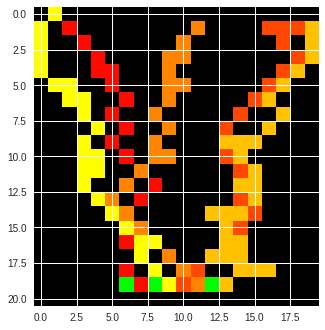

 22%|##2       | 5527/25000 [53:31<3:46:30,  1.43episodes/s]

KeyboardInterrupt: ignored

In [ ]:
ep_rewards = [] 

# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    # Update tensorboard step every episode
    agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = np.zeros (num_peds)
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    env_rndr= env.get_env()
    while not done:
        
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state), axis=1)
        else:
            # Get random action
            action = np.random.randint(0, env.ACTION_SPACE_SIZE, size= num_peds)
        
        new_state, reward, done = env.step(action)
        episode_reward += reward
        if not episode % (AGGREGATE_STATS_EVERY):
            print (f'Done in: {step}; {reward}')
            env_rndr= env.render(env_rndr, env.player)
            if done:
                plt.imshow (env_rndr)
                plt.show ()

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1
    ep_rewards.append(episode_reward)
    min_reward = np.mean(np.array(ep_rewards))
    if done and min_reward >= MIN_REWARD:
        agent.model.save(f'models/{MODEL_NAME}_{int(time.time())}.h5')

    # Decay epsilon
    if epsilon > MIN_EPSILON: # and not episode % AGGREGATE_STATS_EVERY :
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

In [ ]:
np.mean(np.array(ep_rewards))

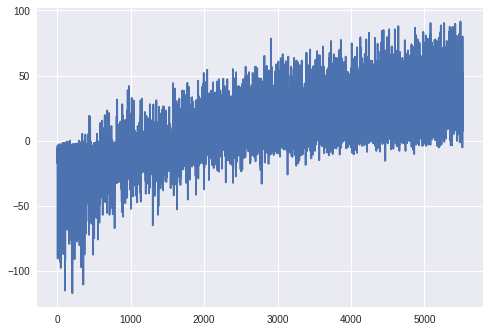

In [ ]:
plt.plot(np.mean(np.array(ep_rewards), axis=1))

In [ ]:
np.save(f'rewards_{MODEL_NAME}_{int(time.time())}.npy', ep_rewards)

In [ ]:
np.sort(ep_rewards[:60])

In [ ]:
np.sort(ep_rewards[-60:])